# CIFAR10 classification using Flax

[Flax](https://flax.readthedocs.io/en/latest/) is a neural network library and ecosystem for JAX that is designed for flexibility. 

GitHub repo: https://github.com/google/flax

[Optax](https://optax.readthedocs.io/en/latest/) is a gradient processing and optimization library for JAX.

## Configuration

Imports

In [1]:
import math
from functools import partial
from collections import defaultdict
from typing import Any, Sequence
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from flax import linen as nn
from flax.training import train_state, common_utils
import optax

import tensorflow as tf
import tensorflow_datasets as tfds

Disable GPU usage by TensorFlow:

In [2]:
tf.config.set_visible_devices([], 'GPU')

In [3]:
jax.local_devices()

[GpuDevice(id=0, process_index=0)]

Configuration

In [4]:
IMAGE_SIZE = 32

NUM_CLASSES = 10
BATCH_SIZE = 32
EPOCHS = 100

LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-2

In [5]:
rng = jax.random.PRNGKey(0)

## Data

In [6]:
def augment_image(img):
    img = tf.image.resize_with_crop_or_pad(img, 40, 40)
    img = tf.image.random_crop(img, [32, 32, 3])
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_saturation(img, 0.8, 1.2)
    return img

In [7]:
def train_process_sample(x):
    image = augment_image(x['image'])
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return {'image': image, 'label': x['label']}

In [8]:
def val_process_sample(x):
    image = tf.image.convert_image_dtype(x['image'], dtype=tf.float32)
    return {'image': image, 'label': x['label']}

In [9]:
def prepare_train_dataset(dataset_builder, batch_size):
    ds = dataset_builder.as_dataset(split='train')
    ds = ds.repeat()
    ds = ds.map(train_process_sample, num_parallel_calls=tf.data.AUTOTUNE)
    df = ds.shuffle(16 * batch_size, reshuffle_each_iteration=True, seed=0)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(10)
    return ds

In [10]:
def prepare_val_dataset(dataset_builder, batch_size):
    ds = dataset_builder.as_dataset(split='test')
    ds = ds.map(val_process_sample, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(10)
    return ds

In [11]:
def tf_to_numpy(xs):
    return jax.tree_map(lambda x: x._numpy(), xs)

In [12]:
def dataset_to_iterator(ds):
    it = map(tf_to_numpy, ds)
    return it

In [13]:
dataset_builder = tfds.builder('cifar10')

In [14]:
dataset_builder.download_and_prepare()

In [15]:
train_steps_per_epoch = math.ceil(dataset_builder.info.splits['train'].num_examples / BATCH_SIZE)
val_steps_per_epoch = math.ceil(dataset_builder.info.splits['test'].num_examples / BATCH_SIZE)

In [16]:
train_ds = prepare_train_dataset(dataset_builder, BATCH_SIZE)
val_ds = prepare_val_dataset(dataset_builder, BATCH_SIZE)

In [17]:
train_iter = dataset_to_iterator(train_ds)
val_iter = dataset_to_iterator(val_ds)

## Model

In [18]:
ModuleDef = Any

In [19]:
class ConvBlock(nn.Module):
    channels: int
    kernel_size: int
    norm: ModuleDef
    stride: int = 1
    act: bool = True
    
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(self.channels, (self.kernel_size, self.kernel_size), strides=self.stride,
                    padding='SAME', use_bias=False, kernel_init=nn.initializers.kaiming_normal())(x)
        x = self.norm()(x)
        if self.act:
            x = nn.swish(x)
        return x

Residual blocks

In [20]:
class ResidualBlock(nn.Module):
    channels: int
    conv_block: ModuleDef
    
    @nn.compact
    def __call__(self, x):
        channels = self.channels
        conv_block = self.conv_block
        
        shortcut = x
        
        residual = conv_block(channels, 3)(x)
        residual = conv_block(channels, 3, act=False)(residual)
        
        if shortcut.shape != residual.shape:
            shortcut = conv_block(channels, 1, act=False)(shortcut)
        
        gamma = self.param('gamma', nn.initializers.zeros, 1, jnp.float32)
        out = shortcut + gamma * residual
        out = nn.swish(out)
        return out

In [21]:
class Stage(nn.Module):
    channels: int
    num_blocks: int
    stride: int
    block: ModuleDef
    
    @nn.compact
    def __call__(self, x):
        stride = self.stride
        if stride > 1:
            x = nn.max_pool(x, (stride, stride), strides=(stride, stride))
        for _ in range(self.num_blocks):
            x = self.block(self.channels)(x)
        return x

In [22]:
class Body(nn.Module):
    channel_list: Sequence[int]
    num_blocks_list: Sequence[int]
    strides: Sequence[int]
    stage: ModuleDef
    
    @nn.compact
    def __call__(self, x):
        for channels, num_blocks, stride in zip(self.channel_list, self.num_blocks_list, self.strides):
            x = self.stage(channels, num_blocks, stride)(x)
        return x

ResNet

In [23]:
class Stem(nn.Module):
    channel_list: Sequence[int]
    stride: int
    conv_block: ModuleDef
    
    @nn.compact
    def __call__(self, x):
        for channels in self.channel_list:
            x = self.conv_block(channels, 3, stride=self.stride)(x)
        return x

In [24]:
class Head(nn.Module):
    classes: int
    dropout: ModuleDef
    
    @nn.compact
    def __call__(self, x):
        x = jnp.mean(x, axis=(1, 2))
        x = self.dropout()(x)
        x = nn.Dense(self.classes)(x)
        return x

In [25]:
class ResNet(nn.Module):
    classes: int
    channel_list: Sequence[int]
    num_blocks_list: Sequence[int]
    strides: Sequence[int]
    head_p_drop: float = 0.
    
    @nn.compact
    def __call__(self, x, train=True):
        norm = partial(nn.BatchNorm, use_running_average=not train)
        dropout = partial(nn.Dropout, rate=self.head_p_drop, deterministic=not train)
        conv_block = partial(ConvBlock, norm=norm)
        residual_block = partial(ResidualBlock, conv_block=conv_block)
        stage = partial(Stage, block=residual_block)
        
        x = Stem([32, 32, 64], self.strides[0], conv_block)(x)
        x = Body(self.channel_list, self.num_blocks_list, self.strides[1:], stage)(x)
        x = Head(self.classes, dropout)(x)
        return x

In [26]:
@jax.jit
def initialize(params_rng):
    init_rngs = {'params': params_rng}
    input_shape = (1, IMAGE_SIZE, IMAGE_SIZE, 3)
    variables = model.init(init_rngs, jnp.ones(input_shape, jnp.float32), train=False)
    return variables

In [27]:
model = ResNet(NUM_CLASSES,
               channel_list = [64, 128, 256, 512],
               num_blocks_list = [2, 2, 2, 2],
               strides = [1, 1, 2, 2, 2],
               head_p_drop = 0.3)

In [28]:
params_rng, dropout_rng = jax.random.split(rng)

In [29]:
variables = initialize(params_rng)

## Training

### Loss

In [30]:
def cross_entropy_loss(logits, labels):
    one_hot_labels = common_utils.onehot(labels, num_classes=NUM_CLASSES)
    loss = optax.softmax_cross_entropy(logits=logits, labels=one_hot_labels)
    loss = jnp.mean(loss)
    return loss

### Metrics

In [31]:
def compute_metrics(logits, labels):
    loss = cross_entropy_loss(logits, labels)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
      'loss': loss,
      'accuracy': accuracy,
    }
    return metrics

### Optimizer

In [32]:
num_train_steps = train_steps_per_epoch * EPOCHS

In [33]:
shedule_fn = optax.cosine_onecycle_schedule(transition_steps=num_train_steps, peak_value=LEARNING_RATE)

In [34]:
tx = optax.adamw(learning_rate=shedule_fn, weight_decay=WEIGHT_DECAY)

### Train state

In [35]:
class TrainState(train_state.TrainState):
    batch_stats: Any

In [36]:
state = TrainState.create(
    apply_fn = model.apply,
    params = variables['params'],
    batch_stats = variables['batch_stats'],
    tx = tx)

### Train functions

In [37]:
@jax.jit
def train_step(state, batch, dropout_rng):
    dropout_rng = jax.random.fold_in(dropout_rng, state.step)
    
    def loss_fn(params):
        variables = {'params': params, 'batch_stats': state.batch_stats}
        logits, new_model_state = state.apply_fn(variables, batch['image'], train=True,
                                                 rngs={'dropout': dropout_rng}, mutable='batch_stats')
        loss = cross_entropy_loss(logits, batch['label'])
        return loss, (new_model_state, logits)
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    aux, grads = grad_fn(state.params)
    new_model_state, logits = aux[1]
    metrics = compute_metrics(logits, batch['label'])
    new_state = state.apply_gradients(grads=grads, batch_stats=new_model_state['batch_stats'])
    return new_state, metrics

In [38]:
@jax.jit
def eval_step(state, batch):
    variables = {'params': state.params, 'batch_stats': state.batch_stats}
    logits = state.apply_fn(variables, batch['image'], train=False, mutable=False)
    metrics = compute_metrics(logits, batch['label'])
    return metrics

In [39]:
def metrics_summary(metrics):
    metrics = jax.device_get(metrics)
    metrics = jax.tree_multimap(lambda *args: np.stack(args), *metrics)
    summary = jax.tree_map(lambda x: x.mean(), metrics)
    return summary

In [40]:
def log_metrics(history, summary, name):
    print(f"{name}: ", end='', flush=True)
    for key, val in summary.items():
        history[name + ' ' + key].append(val)
        print(f"{key} {val:.3f} ", end='')

In [41]:
def train(state, train_iter, val_iter, epochs):
    history = defaultdict(list)
    
    for epoch in range(1, epochs + 1):
        print(f"{epoch}/{epochs} - ", end='')
        
        train_metrics = []
        for step in range(train_steps_per_epoch):
            batch = next(train_iter)
            state, metrics = train_step(state, batch, dropout_rng)
            train_metrics.append(metrics)
        
        summary = metrics_summary(train_metrics)
        log_metrics(history, summary, 'train')
        print('; ', end='')
        
        val_metrics = []
        for step in range(val_steps_per_epoch):
            batch = next(val_iter)
            metrics = eval_step(state, batch)
            val_metrics.append(metrics)
        
        summary = metrics_summary(val_metrics)
        log_metrics(history, summary, 'val')
        print()
    
    return history

### Start training

In [42]:
history = train(state, train_iter, val_iter, EPOCHS)

1/100 - train: accuracy 0.519 loss 1.333 ; val: accuracy 0.679 loss 0.929 
2/100 - train: accuracy 0.716 loss 0.819 ; val: accuracy 0.737 loss 0.788 
3/100 - train: accuracy 0.773 loss 0.664 ; val: accuracy 0.770 loss 0.670 
4/100 - train: accuracy 0.799 loss 0.584 ; val: accuracy 0.799 loss 0.596 
5/100 - train: accuracy 0.816 loss 0.535 ; val: accuracy 0.800 loss 0.597 
6/100 - train: accuracy 0.831 loss 0.493 ; val: accuracy 0.781 loss 0.735 
7/100 - train: accuracy 0.840 loss 0.467 ; val: accuracy 0.810 loss 0.566 
8/100 - train: accuracy 0.849 loss 0.441 ; val: accuracy 0.806 loss 0.607 
9/100 - train: accuracy 0.857 loss 0.418 ; val: accuracy 0.807 loss 0.585 
10/100 - train: accuracy 0.863 loss 0.398 ; val: accuracy 0.806 loss 0.625 
11/100 - train: accuracy 0.870 loss 0.381 ; val: accuracy 0.826 loss 0.568 
12/100 - train: accuracy 0.875 loss 0.363 ; val: accuracy 0.787 loss 0.738 
13/100 - train: accuracy 0.877 loss 0.357 ; val: accuracy 0.825 loss 0.585 
14/100 - train: accur

In [43]:
def plot_history_train_val(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history['train ' + key]) + 1)
    ax.plot(xs, history['train ' + key], '.-', label='train')
    ax.plot(xs, history['val ' + key], '.-', label='val')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.legend()
    ax.grid()
    plt.show()

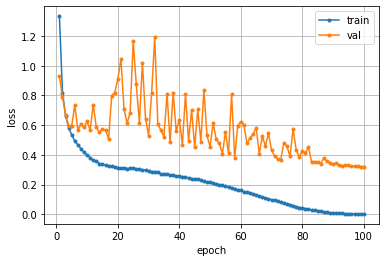

In [44]:
plot_history_train_val(history, 'loss')

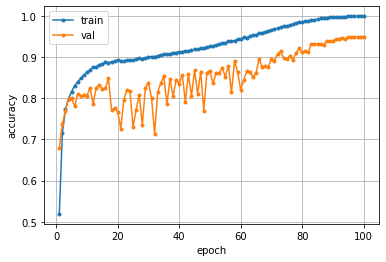

In [45]:
plot_history_train_val(history, 'accuracy')